In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

In [ ]:
ratings = pd.read_csv('/kaggle/input/ratings/Products_ThoiTrangNam_rating_raw.csv', header=0, sep="\t")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024482 entries, 0 to 1024481
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   product_id  1024482 non-null  int64 
 1   user_id     1024482 non-null  int64 
 2   user        1024482 non-null  object
 3   rating      1024482 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 31.3+ MB


In [ ]:
ratings.head()

,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


In [ ]:
# Check duplicates
ratings.duplicated().value_counts()

False    999815
True      24667
Name: count, dtype: int64

In [ ]:
ratings.drop_duplicates(inplace=True)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999815 entries, 0 to 1024481
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   product_id  999815 non-null  int64 
 1   user_id     999815 non-null  int64 
 2   user        999815 non-null  object
 3   rating      999815 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 38.1+ MB


In [ ]:
ratings['rating'].value_counts()

rating
5    755695
4    116961
3     62461
1     40822
2     23876
Name: count, dtype: int64

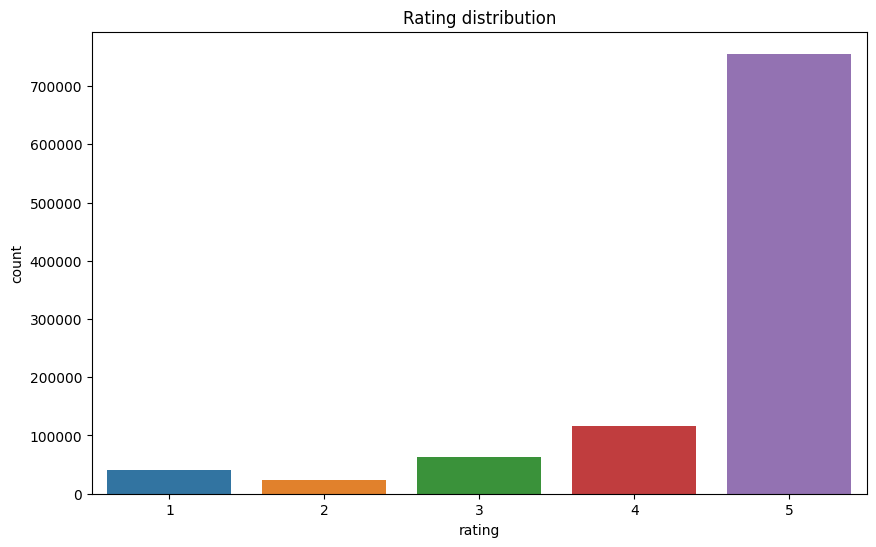

In [ ]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Rating distribution')
plt.show()

In [ ]:
print(f"Tổng số đánh giá: {len(ratings):,}")
print(f"Số user duy nhất: {ratings['user_id'].nunique():,}")
print(f"Số sản phẩm được đánh giá: {ratings['product_id'].nunique():,}")

Tổng số đánh giá: 999,815
Số user duy nhất: 650,636
Số sản phẩm được đánh giá: 31,267


In [ ]:
print(f"Số lượng đánh giá ít nhất cho một sản phẩm: {ratings['product_id'].value_counts().min()}")
print(f"Số lượng đánh giá nhiều nhất cho một sản phẩm: {ratings['product_id'].value_counts().max()}")
print(f"Số lượng 1 người đánh giá ít nhất bao nhiều sản phẩm: {ratings['user_id'].value_counts().min()}")
print(f"Số lượng 1 người đánh giá nhiều nhất bao nhiều sản phẩm: {ratings['user_id'].value_counts().max()}")

Số lượng đánh giá ít nhất cho một sản phẩm: 1
Số lượng đánh giá nhiều nhất cho một sản phẩm: 406
Số lượng 1 người đánh giá ít nhất bao nhiều sản phẩm: 1
Số lượng 1 người đánh giá nhiều nhất bao nhiều sản phẩm: 13010


In [ ]:
# Lọc users và items có ít tương tác
min_user_ratings = 3  # Chỉ giữ users có ít nhất 3 ratings
min_item_ratings = 5   # Chỉ giữ items có ít nhất 5 ratings

# Đếm số lượng ratings mỗi user
user_rating_counts = ratings['user_id'].value_counts()

# Đếm số lượng ratings mỗi item
item_rating_counts = ratings['product_id'].value_counts()

# Lọc dữ liệu
filtered_df = ratings[
    ratings['user_id'].isin(user_rating_counts[user_rating_counts >= min_user_ratings].index) &
    ratings['product_id'].isin(item_rating_counts[item_rating_counts >= min_item_ratings].index)
]
print("Kích thước sau lọc:", filtered_df.shape)

Kích thước sau lọc: (298151, 4)


In [ ]:
# Phân phối rating hiện tại
filtered_df['rating'].value_counts()

rating
5    230371
4     31217
3     16311
1     12734
2      7518
Name: count, dtype: int64

In [ ]:
# Downsampling rating 5 sao
rating_5 = filtered_df[filtered_df['rating'] == 5].sample(n=100000, random_state=42)
other_ratings = filtered_df[filtered_df['rating'] != 5]

In [ ]:
# Kết hợp lại
balanced_df = pd.concat([rating_5, other_ratings])

print("Phân phối rating sau cân bằng:")
print(balanced_df['rating'].value_counts())

Phân phối rating sau cân bằng:
rating
5    100000
4     31217
3     16311
1     12734
2      7518
Name: count, dtype: int64


In [ ]:
balanced_df

,product_id,user_id,user,rating
456172,23653,159123,nguyenthai89,5
60353,20971,486,h*****4,5
759357,15362,199,Người dùng Shopee,5
423446,233913,831,t*****1,5
606430,11630,230,p*****6,5
...,...,...,...,...
1024098,171101,69846,hsjiuahjjjdh,3
1024099,171101,49327,j*****o,2
1024191,171102,602197,thuynguyen1232641,3
1024197,171102,199,Người dùng Shopee,3


In [ ]:
n_ratings = len(balanced_df)
n_products = len(balanced_df['product_id'].unique())
n_users = len(balanced_df['user_id'].unique())

In [ ]:
display(n_ratings, n_products, n_users)

167780

20364

27966

In [ ]:
!pip install surprise

In [ ]:
from surprise import *
from surprise.model_selection.validation import cross_validate

In [ ]:
reader = Reader()
data = Dataset.load_from_df(balanced_df[['user_id', 'product_id', 'rating']], reader)

In [ ]:
# Thiết lập tham số mặc định
sim_options = {
    'name': 'pearson_baseline',
    'user_based': False,
    'min_support': 5,
    'shrinkage': 100
}

knn = KNNBasic(
    k=30,
    min_k=3,
    sim_options=sim_options,
    verbose=False
)

In [ ]:
results = cross_validate(
    knn,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,  # 5-fold cross-validation
    verbose=True
)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2844  1.2780  1.2818  1.2872  1.2803  1.2823  0.0032  
MAE (testset)     1.0521  1.0470  1.0490  1.0544  1.0470  1.0499  0.0029  
Fit time          27.18   27.04   26.89   26.89   27.23   27.05   0.14    
Test time         9.93    9.88    9.86    9.89    9.83    9.88    0.03    


In [ ]:
results

{'test_rmse': array([1.2843881 , 1.27804379, 1.28179979, 1.28724015, 1.28027634]),
 'test_mae': array([1.0521325 , 1.0470061 , 1.04904501, 1.05440252, 1.04703545]),
 'fit_time': (27.183940410614014,
  27.036832809448242,
  26.893598318099976,
  26.894986152648926,
  27.228182554244995),
 'test_time': (9.933596849441528,
  9.882787704467773,
  9.858349561691284,
  9.888023138046265,
  9.829805374145508)}

In [ ]:
## Cấu hình tối ưu đã kiểm nghiệm (balance giữa chất lượng và tốc độ)
optimized_config = {
    'n_factors': 35,
    'n_epochs': 40,
    'lr_all': 0.0045,
    'reg_all': 0.12,
    'init_std_dev': 0.05,
    'random_state': 42,
    'verbose': False
}

## 2. Khởi tạo mô hình SVD ++
model = SVDpp(**optimized_config)

In [ ]:
cv_results = cross_validate(
    model,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=True
)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0896  1.1173  1.0958  1.0996  1.1029  1.1010  0.0092  
MAE (testset)     0.8293  0.8459  0.8335  0.8349  0.8388  0.8365  0.0056  
Fit time          509.77  513.47  509.82  510.39  502.11  509.11  3.76    
Test time         16.07   17.94   17.47   17.35   16.10   16.99   0.76    


In [ ]:
cv_results

{'test_rmse': array([1.08959371, 1.11727837, 1.09584656, 1.09955229, 1.10287644]),
 'test_mae': array([0.82927676, 0.84593543, 0.8334868 , 0.83492548, 0.83880026]),
 'fit_time': (509.77292799949646,
  513.4726822376251,
  509.8236119747162,
  510.3856029510498,
  502.10738730430603),
 'test_time': (16.06616449356079,
  17.94470500946045,
  17.467593669891357,
  17.35291600227356,
  16.095858812332153)}

In [ ]:
## 4. Hiển thị kết quả chi tiết
print("\nKết quả so sánh với KNNBasic:")
print(f"{'Metric':<10} | {'KNNBasic':<10} | {'SVD++ (Optimized)':<16} | Improvement")
print("-" * 55)
print(f"{'RMSE':<10} | {np.mean(results['test_rmse']):<10.4f} | {np.mean(cv_results['test_rmse']):<16.4f} | {100*(np.mean(results['test_rmse'])-np.mean(cv_results['test_rmse']))/1.2823:.1f}%")
print(f"{'MAE':<10} | {np.mean(results['test_mae']):<10.4f} | {np.mean(cv_results['test_mae']):<16.4f} | {100*(np.mean(results['test_mae'])-np.mean(cv_results['test_mae']))/1.0499:.1f}%")


Kết quả so sánh với KNNBasic:
Metric     | KNNBasic   | SVD++ (Optimized) | Improvement
-------------------------------------------------------
RMSE       | 1.2823     | 1.1010           | 14.1%
MAE        | 1.0499     | 0.8365           | 20.3%


In [ ]:
# 5. Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("\nĐang huấn luyện mô hình cuối cùng...")
trainset = data.build_full_trainset()
model.fit(trainset)


Đang huấn luyện mô hình cuối cùng...


# Recommender for a specific user

In [ ]:
product = pd.read_csv('/kaggle/input/product/products_not_duplicates.csv', header=0)
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49653 entries, 0 to 49652
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49653 non-null  int64  
 1   product_name  49653 non-null  object 
 2   category      49653 non-null  object 
 3   sub_category  49653 non-null  object 
 4   link          49653 non-null  object 
 5   image         36433 non-null  object 
 6   price         49653 non-null  float64
 7   rating        49653 non-null  float64
 8   description   48690 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB


In [ ]:
df = ratings.merge(product[['product_id', 'product_name', 'sub_category']], on='product_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999815 entries, 0 to 999814
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   product_id    999815 non-null  int64 
 1   user_id       999815 non-null  int64 
 2   user          999815 non-null  object
 3   rating        999815 non-null  int64 
 4   product_name  994553 non-null  object
 5   sub_category  994553 non-null  object
dtypes: int64(3), object(3)
memory usage: 45.8+ MB


In [ ]:
userId = 831
df_select = df[(df['user_id'] == userId) & (df['rating'] ==5)]
df_select = df_select[[
    'product_id',
    'product_name',
    'sub_category',
    'rating',
    'user'
]]

df_select = df_select.set_index('product_id')
df_select.head(df_select.shape[0])

,product_name,sub_category,rating,user
product_id,,,,
1910,Áo Ba Lỗ Nam Cao Cấp Aristino Thun 3 Lỗ Lót Tr...,Áo Ba Lỗ,5,t*****1
1913,"Áo Sát Nách Nam Cotton 5S (6 màu), Kiểu Dáng T...",Áo Ba Lỗ,5,t*****1
1914,Áo Ba Lỗ Sát Nách TankTop Nam Nữ Vải Cotton 10...,Áo Ba Lỗ,5,t*****1
1915,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...,Áo Ba Lỗ,5,t*****1
1920,Áo Ba Lỗ Sát Nách Nam Tập Gym Thể Thao Cao Cấp...,Áo Ba Lỗ,5,t*****1
...,...,...,...,...
171061,TẤT(VỚ) thổ cẩm cao cổ cho nam chất liệu len c...,Vớ/Tất,5,t*****1
171079,Tất nam cổ cao TIMAN TNS06 kháng khuẩn khử mùi...,Vớ/Tất,5,t*****1
171084,"Tất cổ cao nam nữ METAT, vớ cao cổ len lông cừ...",Vớ/Tất,5,t*****1


In [ ]:
df_select.shape

(1724, 4)

In [ ]:
userId2 = 486
df_select2 = df[(df['user_id'] == userId2) & (df['rating'] ==5)]
df_select2 = df_select2[[
    'product_id',
    'rating',
    'user'
]]

# df_select2 = df_select2.set_index('product_id')
df_select2.head(df_select2.shape[0])

,product_id,rating,user
3093,1929,5,h*****4
4204,1946,5,h*****4
4271,1948,5,h*****4
5518,1971,5,h*****4
9145,19170,5,h*****4
...,...,...,...
993294,17997,5,h*****4
993585,171000,5,h*****4
994720,171020,5,h*****4
996431,171045,5,h*****4


In [ ]:
df_select2.duplicated().value_counts()

False    885
Name: count, dtype: int64

In [ ]:
df_score = df[['product_id']]
df_score

,product_id
0,190
1,190
2,190
3,190
4,190
...,...
999810,171107
999811,171107
999812,171107
999813,171107


In [ ]:
df_score = df_score.drop_duplicates()
df_score

,product_id
0,190
184,191
334,192
523,193
719,194
...,...
999533,171103
999574,171104
999605,171105
999689,171106


In [ ]:
# Evaluated
df_score['EstimateScore'] = df_score['product_id'].apply(lambda x: model.predict(userId, x).est)
df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)

In [ ]:
df_score.head()

,product_id,EstimateScore
449443,23707,4.307558
32347,20209,4.298078
870504,17305,4.255983
801705,14577,4.254552
861069,17205,4.249320


In [ ]:
# Những product có điểm lớn hơn 4
df_score[df_score.EstimateScore>=4]

,product_id,EstimateScore
449443,23707,4.307558
32347,20209,4.298078
870504,17305,4.255983
801705,14577,4.254552
861069,17205,4.249320
...,...,...
424684,23509,4.000771
567360,1157,4.000750
102084,21395,4.000615
548217,25856,4.000416


In [ ]:
df_score2 = df[['product_id', 'product_name']]
df_score2 = df_score2.drop_duplicates()

In [ ]:
# Evaluated
df_score2['EstimateScore'] = df_score2['product_id'].apply(lambda x: model.predict(userId2, x).est)
df_score2 = df_score2.sort_values(by=['EstimateScore'], ascending=False)

In [ ]:
df_score2.head()

,product_id,product_name,EstimateScore
449443,23707,Áo hoodie dáng rộng phong cách Hàn Quốc trẻ tr...,4.475007
950093,174039,Tất Nam Uniqlo Chống Hôi Chân Cổ Ngắn Hàng Chuẩn,4.442439
801705,14577,Quần Jeans trơn KK05 GUY's Closet kiểu basic ố...,4.438483
870504,17305,Tất Ngắn Muji Xuất dư chuẩn xịn ( Trắng đen xá...,4.437688
32347,20209,Áo nỉ da cá nam dài tay T41,4.426593


In [ ]:
# Những product có điểm lớn hơn 4
df_score2[df_score2.EstimateScore>=4]

,product_id,product_name,EstimateScore
449443,23707,Áo hoodie dáng rộng phong cách Hàn Quốc trẻ tr...,4.475007
950093,174039,Tất Nam Uniqlo Chống Hôi Chân Cổ Ngắn Hàng Chuẩn,4.442439
801705,14577,Quần Jeans trơn KK05 GUY's Closet kiểu basic ố...,4.438483
870504,17305,Tất Ngắn Muji Xuất dư chuẩn xịn ( Trắng đen xá...,4.437688
32347,20209,Áo nỉ da cá nam dài tay T41,4.426593
...,...,...,...
729812,151462,"COMBO 6 Quần ngủ nam LAVIC, chất vải thun cott...",4.000230
533504,25518,Combo 5 quần lót nam tam giác Nhật thông hơi c...,4.000140
52195,20673,[CÓ VIDEO + HÌNH THẬT] Áo thun Unisex tay lỡ F...,4.000084
129471,21976,"Áo khoác Bape X PUBG, Áo Khoác Bape nhiều màu",4.000077
